
# ADS‑B @ 1090 MHz — RTL‑SDR Detect & Decode (with Debug Plots)

This version adds **diagnostic outputs** and **visualizations** to help students understand each step.

**Pipeline:** IQ (CU8) → DC removal → Magnitude → (optional) oversample → Preamble detection → PPM slice → CRC/PI check → Summaries & plots.

> Uses the faster detector in `adsb_lib_v3fast.py` for snappy runs on class machines.



## 0) Quick Setup & Tips

**Capture example (3 s @ 2 MS/s, manual gain):**
```bash
rtl_sdr -f 1090000000 -s 2000000 -g 49.6 -n $((3*2000000*2)) capture_1090.cu8
```
- output is **CU8** (I then Q), 2 bytes per complex sample → use `fmt='cu8'`
- start smaller and scale up later for speed



## 1) Imports (fast library)


In [1]:

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import importlib.util, sys, time

# Use the fast library
lib_path = Path('adsb_lib_v3fast.py')
assert lib_path.exists(), "adsb_lib_v3fast.py not found next to this notebook."
spec = importlib.util.spec_from_file_location('adsb_lib_v3fast', lib_path)
adsb = importlib.util.module_from_spec(spec)
sys.modules['adsb_lib_v3fast'] = adsb
spec.loader.exec_module(adsb)

[name for name in dir(adsb) if not name.startswith('_')][:20]


['Any',
 'DecodeConfig',
 'Detection',
 'Dict',
 'Frame',
 'IQSamples',
 'List',
 'Optional',
 'Path',
 'Sequence',
 'Tuple',
 'Union',
 'annotations',
 'bits_to_hex',
 'bits_to_int',
 'bits_to_ppm_wave',
 'crc24_compute',
 'dataclass',
 'dc_remove',
 'decode_frames']


## 2) Student Configuration


In [2]:

# ---- Config ----
iq_path = Path('capture_1090.cu8')  # your RTL-SDR dump
fmt = 'cu8'                         # 'cu8' for rtl_sdr, 'cf32' if float32
fs = 2_000_000                      # Hz
max_samples = 2_000_000             # start small; set None to load all

# Detector/decoder
up = 1                # start with 1 for speed; try 2..4 for robustness
min_snr = 6.0
cfg = adsb.DecodeConfig(up=up, min_snr=min_snr)

print(f"Params → fs={fs} Hz, up={up}, min_snr={min_snr}, max_samples={max_samples}")


Params → fs=2000000 Hz, up=1, min_snr=6.0, max_samples=2000000



## 3) Load → Preprocess → Detect → Decode (with timing)


In [3]:

t0 = time.time()
iq = adsb.load_iq(iq_path, fmt=fmt, fs=fs, max_samples=max_samples)
t1 = time.time()
x = adsb.dc_remove(iq.samples)
mag = adsb.to_magnitude(x)
mag_up, fs_up = adsb.mag_oversample(mag, iq.fs, up=up)
t2 = time.time()
dets = adsb.detect_preambles(mag_up, fs_up, min_snr=min_snr, up=up)
t3 = time.time()
frames = adsb.decode_frames(mag_up, fs_up, dets, cfg=cfg)
t4 = time.time()

print(f"Load: {t1-t0:.3f}s  Preprocess: {t2-t1:.3f}s  Detect: {t3-t2:.3f}s  Decode: {t4-t3:.3f}s")
print(f"Detections: {len(dets)} | Frames: {len(frames)}")


Load: 0.149s  Preprocess: 0.007s  Detect: 0.113s  Decode: 141.373s
Detections: 43517 | Frames: 435170



## 4) Frame Summary


In [4]:

def icao_hex(v): return f"{v:06X}" if v is not None else "--"
print("p0\tlen\tDF\tICAO\tCRC_OK\tHEX[:32]...")
for fr in frames[:30]:
    crc_str = "?" if fr.crc_ok is None else ("OK" if fr.crc_ok else "BAD")
    print(f"{fr.p0}\t{fr.length_bits}\t{fr.df if fr.df is not None else '--'}\t{icao_hex(fr.icao)}\t{crc_str}\t{fr.hex[:32]}...")


p0	len	DF	ICAO	CRC_OK	HEX[:32]...
22	112	3	748421	BAD	1C74842190D644908829C4EC294E...
22	56	3	748421	BAD	1C74842190D644...
23	112	26	0AB77C	BAD	D40AB77C7D61774D73C61B172230...
23	56	26	0AB77C	BAD	D40AB77C7D6177...
24	112	7	E90843	BAD	38E9084321AC8921105389D8529D...
24	56	7	E90843	BAD	38E9084321AC89...
25	112	21	156EF8	BAD	A8156EF8FAC2EE9AE78C362E4461...
25	56	21	156EF8	BAD	A8156EF8FAC2EE...
26	112	14	D21086	BAD	71D210864359124220A713B0A53A...
26	56	14	D21086	BAD	71D21086435912...
106	112	11	124220	BAD	59124220A713B0A53AE2B66441DD...
106	56	11	124220	BAD	59124220A713B0...
107	112	16	DD35CF	BAD	85DD35CF186C5C88C21020221664...
107	56	16	DD35CF	BAD	85DD35CF186C5C...
108	112	22	248441	BAD	B22484414E27614A75C56CC883BA...
108	56	22	248441	BAD	B22484414E2761...
109	112	1	BA6B9E	BAD	0BBA6B9E30D8B911842040442CC9...
109	56	1	BA6B9E	BAD	0BBA6B9E30D8B9...
110	112	12	490882	BAD	644908829C4EC294EB8AD9910774...
110	56	12	490882	BAD	644908829C4EC2...
115	112	11	D35CF1	BAD	5DD35CF186C5C88C21020221664D..


## 5) Debug: Preamble Neighborhood (Magnitude + Correlation + Threshold)

We recompute a correlation trace around the first detection and plot it with a heuristic threshold.


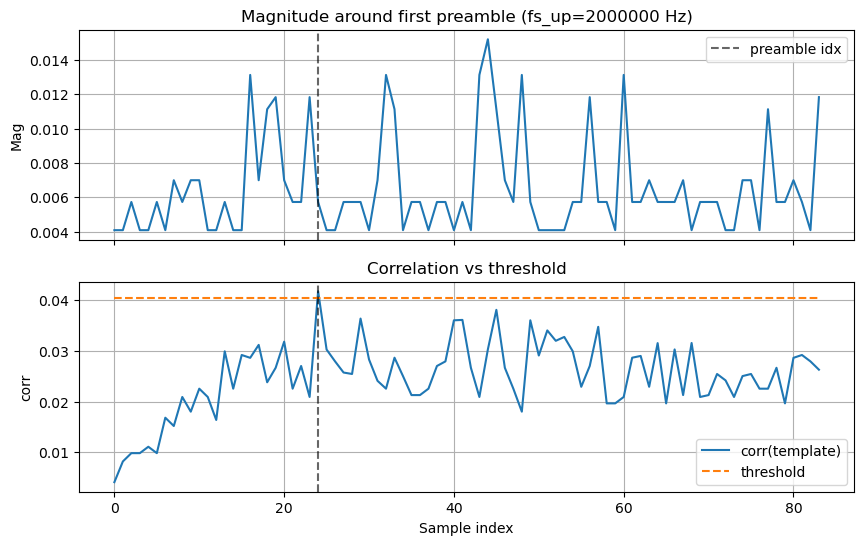

In [5]:

if len(dets):
    p0 = dets[0].p0
    # Window around p0 for plotting
    win = int(60e-6 * fs_up)  # ~60 µs window
    s = max(0, p0 - win//2)
    e = min(len(mag_up), p0 + win//2)

    # Build preamble template and correlation (for visualization)
    def preamble_template(fs):
        us = lambda micro: int(round((micro*1e-6)*fs))
        segs = [(0.0,0.5,1.0),(0.5,1.0,0.0),(1.0,1.5,1.0),(1.5,3.5,0.0),
                (3.5,4.0,1.0),(4.0,5.5,0.0),(5.5,6.0,1.0),(6.0,8.0,0.0)]
        L = max(us(8.0), 8); tpl = np.zeros(L, dtype=np.float32)
        for a,b,val in segs: tpl[us(a):us(b)] = val
        if np.max(tpl)>0: tpl /= np.max(tpl)
        return tpl

    tpl = preamble_template(fs_up)
    corr_full = np.convolve(mag_up, tpl[::-1], mode='same')
    corr = corr_full[s:e]

    # Fast global median/MAD threshold (mirrors v3fast idea)
    m = np.median(corr_full)
    mad = np.median(np.abs(corr_full - m)) + 1e-6
    thr = m + (min_snr/2.0)*mad
    thr_seg = np.full_like(corr, thr)

    # Plot magnitude and correlation
    t_idx = np.arange(s, e)
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    ax[0].plot(t_idx, mag_up[s:e])
    ax[0].axvline(p0, color='k', linestyle='--', alpha=0.6, label='preamble idx')
    ax[0].set_title(f'Magnitude around first preamble (fs_up={fs_up:.0f} Hz)')
    ax[0].set_ylabel('Mag'); ax[0].grid(True); ax[0].legend()

    ax[1].plot(t_idx, corr, label='corr(template)')
    ax[1].plot(t_idx, thr_seg, linestyle='--', label='threshold')
    ax[1].axvline(p0, color='k', linestyle='--', alpha=0.6)
    ax[1].set_title('Correlation vs threshold')
    ax[1].set_xlabel('Sample index'); ax[1].set_ylabel('corr'); ax[1].grid(True); ax[1].legend()
else:
    print("No detections to debug.")



## 6) Debug: Bit‑Slicing Visualization (first frame)

Shows where the slicer looks for energy and the resulting bits; also compares half‑bit energies.


TypeError: stem() got an unexpected keyword argument 'use_line_collection'

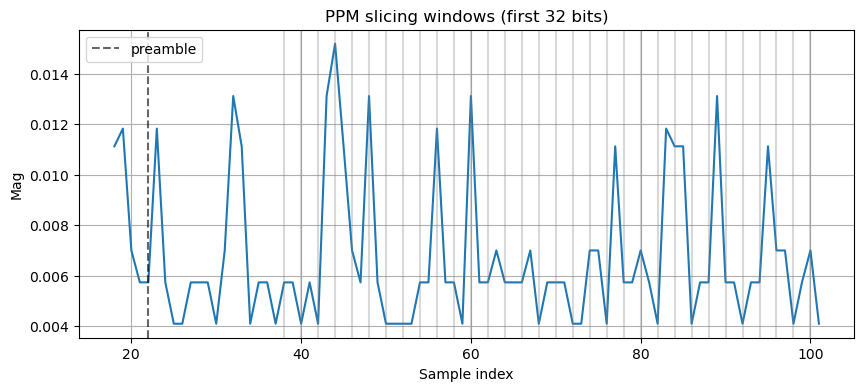

<Figure size 1000x300 with 0 Axes>

In [ ]:

def visualize_bits(mag_up, fs_up, p0, bits_to_show=24, nbits=112):
    # Draw windows and compute per-bit energies
    start = p0 + int(round(8e-6*fs_up))
    spb = fs_up / 1e6
    h = int(round(0.5e-6*fs_up))

    a_en = []
    b_en = []
    for k in range(min(bits_to_show, nbits)):
        s = int(round(start + k*spb))
        a = np.sum(mag_up[s:s+h])       # first half (bit=1 when A>B)
        b = np.sum(mag_up[s+h:s+2*h])   # second half
        a_en.append(a); b_en.append(b)

    # Plot magnitude with vertical bit boundaries for shown bits
    win = int((8 + bits_to_show + 2) * spb)  # a bit of pad
    s0 = max(0, p0 - int(2*spb))
    e0 = min(len(mag_up), s0 + win)

    x = np.arange(s0, e0)
    plt.figure(figsize=(10,4))
    plt.plot(x, mag_up[s0:e0])
    # preamble marker
    plt.axvline(p0, color='k', linestyle='--', alpha=0.6, label='preamble')
    # bit boundaries (only for shown bits)
    for k in range(bits_to_show+1):
        bx = int(round(start + k*spb))
        if s0 <= bx < e0:
            plt.axvline(bx, color='gray', alpha=0.3)
    plt.title(f'PPM slicing windows (first {bits_to_show} bits)')
    plt.xlabel('Sample index'); plt.ylabel('Mag'); plt.grid(True); plt.legend()

    # Plot half-bit energies for decision margin
    plt.figure(figsize=(10,3))
    kk = np.arange(len(a_en))
    # plt.stem(kk, a_en, basefmt=" ", use_line_collection=True, label='A (first half)')
    # plt.stem(kk, b_en, basefmt=" ", use_line_collection=True, label='B (second half)')
    plt.stem(kk, a_en, basefmt=" ", linefmt="C0-", markerfmt="C0o", label="A (first half)")
    plt.stem(kk, b_en, basefmt=" ", linefmt="C1-", markerfmt="C1o", label="B (second half)")
    plt.legend(); plt.title('Half‑bit energies (decision margin)'); plt.xlabel('Bit #'); plt.ylabel('Energy'); plt.grid(True)

if len(frames):
    fr = frames[0]
    visualize_bits(mag_up, fs_up, fr.p0, bits_to_show=32, nbits=fr.length_bits)
    print("Frame[0]: DF=", fr.df, "ICAO=", f"{fr.icao:06X}" if fr.icao is not None else "--",
          "len=", fr.length_bits, "CRC_OK=", fr.crc_ok)
else:
    print("No frames to visualize.")



## 7) Optional: PSD (short, fast)


In [ ]:

N = min(262_144, len(iq.samples))
x0 = iq.samples[:N] - np.mean(iq.samples[:N])
X = np.fft.fftshift(np.fft.fft(x0))
psd = 20*np.log10(1e-9 + np.abs(X)/np.sqrt(N))
freq = np.fft.fftshift(np.fft.fftfreq(N, d=1/iq.fs))

plt.figure(figsize=(9,3.5))
plt.plot(freq/1e6, psd)
plt.xlabel('Frequency (MHz) relative to center'); plt.ylabel('PSD (dB, arb)')
plt.title('Coarse PSD (short slice)'); plt.grid(True)



## 8) Exercises (Parsing left to students)
1. Implement a DF=17 parser: extract Type Code, aircraft category, and callsign/position/velocity when present.  
2. Count unique ICAO addresses over a 2‑minute capture; plot the top 10.  
3. Compare CRC_OK ratios for `up=1` vs `up=2` on the same capture.
